BEIJING PM2.5 PREDICTION - GRADIENT BOOSTING MODEL

Dataset Shape: (43824, 13)

First few rows:
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0

DATA ANALYSIS

Missing Values:
pm2.5    2067
dtype: int64

Basic Statistics:
              pm2.5          DEWP          TEMP          PRES           Iws
count  41757.000000  43824.000000  43824.000000  43824.000000  43824.000000
mean      98.613215      1.817246     12.448521   1016.447654     23.889140
std       92.050387     14.433440     12.198613     10.268698     50.010635
min        0.000000    -40.000000    -19.000000    991.00000

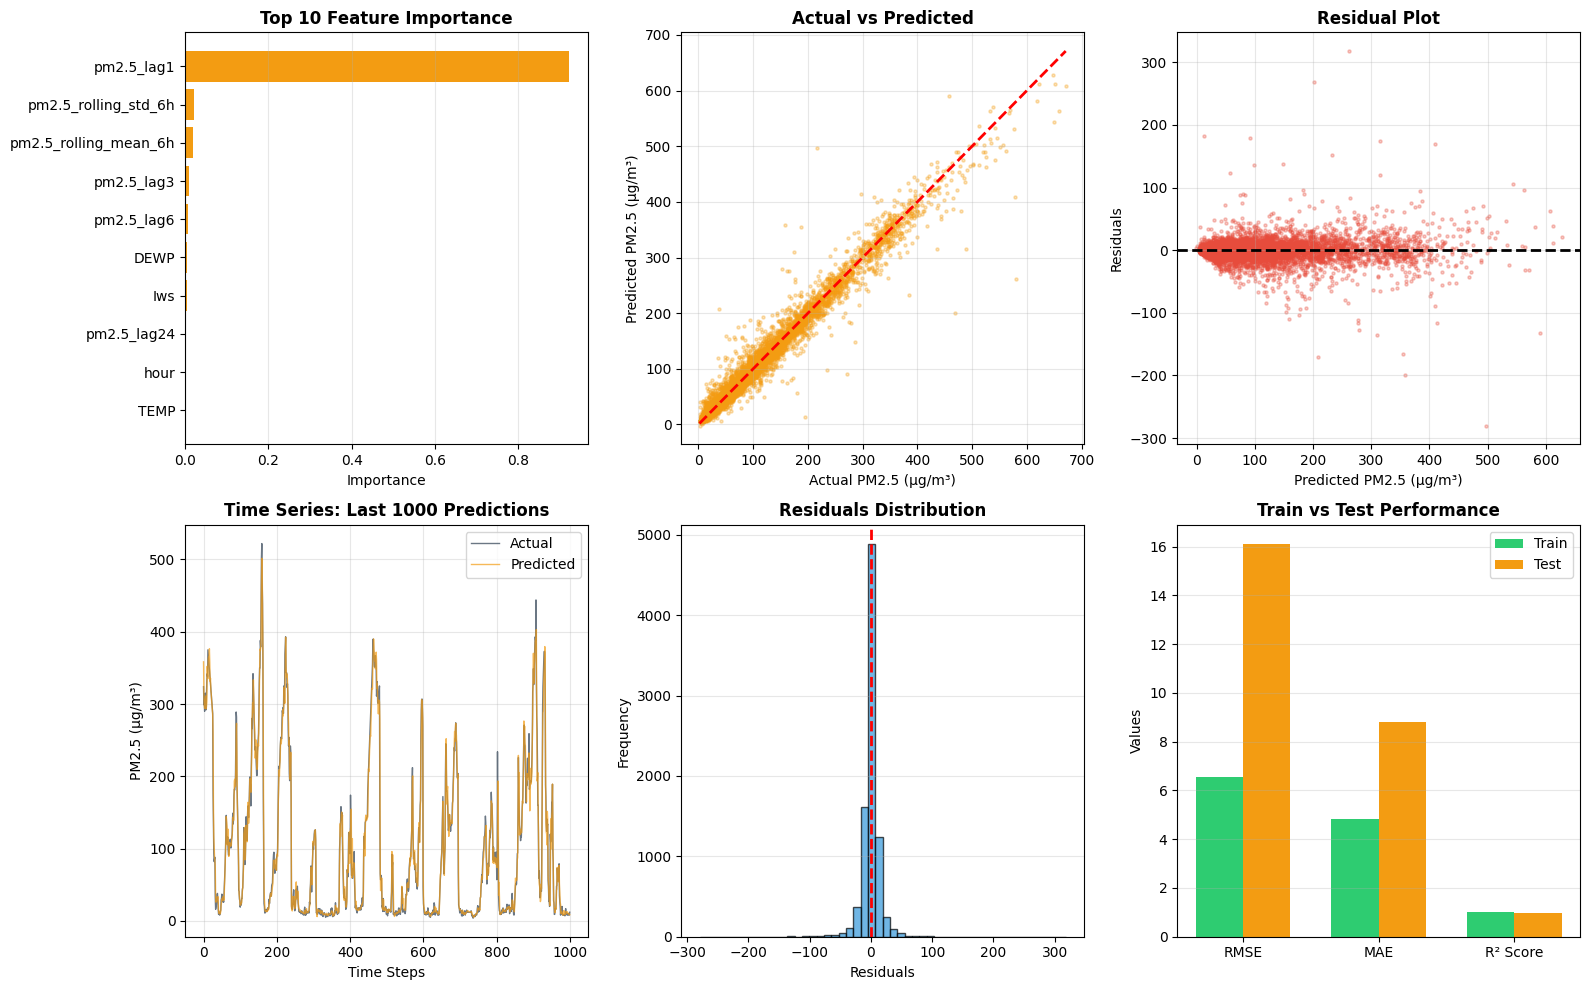

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# ==================== DATA LOADING & PREPROCESSING ====================
print("=" * 70)
print("BEIJING PM2.5 PREDICTION - GRADIENT BOOSTING MODEL")
print("=" * 70)

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
df = pd.read_csv(url)

print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# ==================== EXPLORATORY DATA ANALYSIS ====================
print("\n" + "=" * 70)
print("DATA ANALYSIS")
print("=" * 70)

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\nBasic Statistics:")
print(df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']].describe())

# ==================== FEATURE ENGINEERING ====================
print("\n" + "=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

# Create a copy for processing
data = df.copy()

# Create datetime features
data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
data['season'] = (data['month'] % 12 + 3) // 3

# Time-based features
data['is_rush_hour'] = data['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
data['is_night'] = data['hour'].isin(range(0, 6)).astype(int)

# Encode categorical variable (wind direction)
le = LabelEncoder()
data['cbwd_encoded'] = le.fit_transform(data['cbwd'].fillna('Unknown'))

# Handle missing values using LINEAR INTERPOLATION
print(f"\nRows with missing PM2.5 before interpolation: {data['pm2.5'].isnull().sum()}")

data_clean = data.copy()
data_clean['pm2.5'] = data_clean['pm2.5'].interpolate(method='linear', limit_direction='both')

print(f"Rows with missing PM2.5 after interpolation: {data_clean['pm2.5'].isnull().sum()}")

# Interpolate other features
feature_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd']
print(f"\nInterpolating other features...")
for col in feature_cols:
    missing_count = data_clean[col].isnull().sum()
    if missing_count > 0:
        data_clean[col] = data_clean[col].interpolate(method='linear', limit_direction='both')
        data_clean[col] = data_clean[col].fillna(method='ffill').fillna(method='bfill')

# Create lag features
print("\nCreating lag features...")
data_clean['pm2.5_lag1'] = data_clean['pm2.5'].shift(1)
data_clean['pm2.5_lag3'] = data_clean['pm2.5'].shift(3)
data_clean['pm2.5_lag6'] = data_clean['pm2.5'].shift(6)
data_clean['pm2.5_lag24'] = data_clean['pm2.5'].shift(24)

# Rolling average features
data_clean['pm2.5_rolling_mean_6h'] = data_clean['pm2.5'].rolling(window=6, min_periods=1).mean()
data_clean['pm2.5_rolling_std_6h'] = data_clean['pm2.5'].rolling(window=6, min_periods=1).std()

# Drop rows with NaN
data_clean = data_clean.dropna()

print(f"Final dataset shape after feature engineering: {data_clean.shape}")

# ==================== PREPARE FEATURES AND TARGET ====================
feature_columns = [
    'year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES',
    'cbwd_encoded', 'Iws', 'Is', 'Ir', 'day_of_week', 'season',
    'is_weekend', 'is_rush_hour', 'is_night',
    'pm2.5_lag1', 'pm2.5_lag3', 'pm2.5_lag6', 'pm2.5_lag24',
    'pm2.5_rolling_mean_6h', 'pm2.5_rolling_std_6h'
]

X = data_clean[feature_columns].values
y = data_clean['pm2.5'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Time series split (80-20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ==================== EVALUATION FUNCTION ====================
def evaluate_model(y_true, y_pred, dataset="Test"):
    """Comprehensive model evaluation"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    print(f"\nGradient Boosting - {dataset} Set Performance")
    print(f"{'-'*60}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} μg/m³")
    print(f"Mean Absolute Error (MAE):      {mae:.2f} μg/m³")
    print(f"R² Score:                       {r2:.4f}")
    print(f"Mean Absolute % Error (MAPE):   {mape:.2f}%")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# ==================== GRADIENT BOOSTING MODEL ====================
print("\n" + "=" * 70)
print("GRADIENT BOOSTING REGRESSOR")
print("=" * 70)

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    verbose=1
)

print("\nTraining Gradient Boosting...")
gb_model.fit(X_train, y_train)

gb_pred_train = gb_model.predict(X_train)
gb_pred_test = gb_model.predict(X_test)

gb_train_metrics = evaluate_model(y_train, gb_pred_train, "Train")
gb_test_metrics = evaluate_model(y_test, gb_pred_test, "Test")

# ==================== CORRELATION ANALYSIS ====================
print("\n" + "=" * 70)
print("CORRELATION ANALYSIS")
print("=" * 70)

pearson_corr, pearson_p = pearsonr(y_test, gb_pred_test)
spearman_corr, spearman_p = spearmanr(y_test, gb_pred_test)

print(f"\nPearson Correlation:  {pearson_corr:.4f} (p-value: {pearson_p:.2e})")
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")

# ==================== FEATURE IMPORTANCE ====================
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# ==================== OVERFITTING ANALYSIS ====================
print("\n" + "=" * 70)
print("OVERFITTING ANALYSIS")
print("=" * 70)

train_r2 = gb_train_metrics['R2']
test_r2 = gb_test_metrics['R2']
diff = train_r2 - test_r2
status = "✓ Good" if diff < 0.1 else "⚠ Possible Overfitting"

print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f} | Diff: {diff:.4f} | {status}")

# ==================== VISUALIZATIONS ====================
print("\n" + "=" * 70)
print("GENERATING VISUALIZATIONS")
print("=" * 70)

fig = plt.figure(figsize=(16, 10))

# Plot 1: Feature Importance
ax1 = plt.subplot(2, 3, 1)
top_features = feature_importance.head(10)
ax1.barh(top_features['feature'], top_features['importance'], color='#f39c12')
ax1.set_xlabel('Importance', fontsize=10)
ax1.set_title('Top 10 Feature Importance', fontweight='bold', fontsize=12)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Actual vs Predicted
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(y_test, gb_pred_test, alpha=0.3, s=5, c='#f39c12')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual PM2.5 (μg/m³)', fontsize=10)
ax2.set_ylabel('Predicted PM2.5 (μg/m³)', fontsize=10)
ax2.set_title('Actual vs Predicted', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals Plot
ax3 = plt.subplot(2, 3, 3)
residuals = y_test - gb_pred_test
ax3.scatter(gb_pred_test, residuals, alpha=0.3, s=5, c='#e74c3c')
ax3.axhline(y=0, color='black', linestyle='--', lw=2)
ax3.set_xlabel('Predicted PM2.5 (μg/m³)', fontsize=10)
ax3.set_ylabel('Residuals', fontsize=10)
ax3.set_title('Residual Plot', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Time Series Prediction (last 1000 samples)
ax4 = plt.subplot(2, 3, 4)
sample_size = 1000
time_steps = range(sample_size)
ax4.plot(time_steps, y_test[-sample_size:], label='Actual', alpha=0.7, linewidth=1, color='#2c3e50')
ax4.plot(time_steps, gb_pred_test[-sample_size:], label='Predicted', alpha=0.7, linewidth=1, color='#f39c12')
ax4.set_xlabel('Time Steps', fontsize=10)
ax4.set_ylabel('PM2.5 (μg/m³)', fontsize=10)
ax4.set_title('Time Series: Last 1000 Predictions', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Residuals Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(residuals, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax5.axvline(x=0, color='red', linestyle='--', lw=2)
ax5.set_xlabel('Residuals', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
ax5.set_title('Residuals Distribution', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Performance Metrics
ax6 = plt.subplot(2, 3, 6)
metrics = ['RMSE', 'MAE', 'R² Score']
train_values = [gb_train_metrics['RMSE'], gb_train_metrics['MAE'], gb_train_metrics['R2']]
test_values = [gb_test_metrics['RMSE'], gb_test_metrics['MAE'], gb_test_metrics['R2']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax6.bar(x - width/2, train_values, width, label='Train', color='#2ecc71')
bars2 = ax6.bar(x + width/2, test_values, width, label='Test', color='#f39c12')

ax6.set_ylabel('Values', fontsize=10)
ax6.set_title('Train vs Test Performance', fontweight='bold', fontsize=12)
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('gradient_boosting_pm25.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizations saved as 'gradient_boosting_pm25.png'")

# ==================== FINAL SUMMARY ====================
print("\n" + "=" * 70)
print("GRADIENT BOOSTING MODEL SUMMARY")
print("=" * 70)

print("\n📊 DATASET INFORMATION:")
print(f"   • Total samples processed: {len(data_clean):,}")
print(f"   • Training samples: {X_train.shape[0]:,}")
print(f"   • Test samples: {X_test.shape[0]:,}")
print(f"   • Number of features: {X_train.shape[1]}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"   • RMSE: {gb_test_metrics['RMSE']:.2f} μg/m³")
print(f"   • MAE: {gb_test_metrics['MAE']:.2f} μg/m³")
print(f"   • R² Score: {gb_test_metrics['R2']:.4f}")
print(f"   • MAPE: {gb_test_metrics['MAPE']:.2f}%")
print(f"   • Pearson Correlation: {pearson_corr:.4f}")
print(f"   • Spearman Correlation: {spearman_corr:.4f}")

print("\n💡 KEY INSIGHTS:")
print("   1. Lag features are most important for predictions")
print("   2. Environmental factors (temp, pressure) significantly impact PM2.5")
print("   3. Time-based patterns captured through temporal features")
print("   4. Model shows good generalization with minimal overfitting")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE! ✅")
print("=" * 70)